<div style="width: 100%; background-color: #ef7d22; text-align: center">
<br><br>

<h1 style="color: white; font-weight: bold;">
    Classify the mushrooms into edible or non-edible classes using a decision tree algorithm.
    Be as accurate as possible - it's a matter of life or death!
</h1>


<br><br> 
</div>

![mushrooms](https://user-images.githubusercontent.com/7065401/112419584-6a725800-8d0a-11eb-8c9a-faaf2ba2a08d.png)

<hr>

In [12]:
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.tree import DecisionTreeClassifier,plot_tree
from sklearn.metrics import accuracy_score,confusion_matrix
from sklearn.model_selection import RandomizedSearchCV,train_test_split
from sklearn.preprocessing import LabelEncoder
from scipy.stats import randint

import warnings
warnings.filterwarnings('ignore')

# Step 1: Pull in your data

In [13]:
# Pull in your data
filepath = 'data/mushrooms.csv'
df_mush = pd.read_csv(filepath)
# Look at the first few rows of data
df_mush.describe()

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
count,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124,...,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124
unique,2,6,4,10,2,9,2,2,2,12,...,4,9,9,1,4,3,5,9,6,7
top,e,x,y,n,f,n,f,c,b,b,...,s,w,w,p,w,o,p,w,v,d
freq,4208,3656,3244,2284,4748,3528,7914,6812,5612,1728,...,4936,4464,4384,8124,7924,7488,3968,2388,4040,3148


# Step 1.5: convert categorical columns to numeric using LabelEncoder

In [14]:
# use pandas .info() method to see what columns need to be converted
df_mush.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8124 entries, 0 to 8123
Data columns (total 23 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   class                     8124 non-null   object
 1   cap-shape                 8124 non-null   object
 2   cap-surface               8124 non-null   object
 3   cap-color                 8124 non-null   object
 4   bruises                   8124 non-null   object
 5   odor                      8124 non-null   object
 6   gill-attachment           8124 non-null   object
 7   gill-spacing              8124 non-null   object
 8   gill-size                 8124 non-null   object
 9   gill-color                8124 non-null   object
 10  stalk-shape               8124 non-null   object
 11  stalk-root                8124 non-null   object
 12  stalk-surface-above-ring  8124 non-null   object
 13  stalk-surface-below-ring  8124 non-null   object
 14  stalk-color-above-ring  

## All of the columns are type=object so they all need to be encoded

### But, we actually fit our label encoder on our train data and then transform our test data
### Need to split the data before we can continue

# Step 2: Split data into train and test data

In [15]:
# "class" is the target column
# Split data into test and train - remember to stratify on y
# Pull all of the feature columns into the X dataframe
X = df_mush.drop('class', axis=1).copy()
# Pull the target column into the y series
y = df_mush['class'].copy()
# Split using test_train_split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

In [16]:
# Now we can label encode everything
from collections import defaultdict
d = defaultdict(LabelEncoder)
# Encoding the variable
X_train_encoded = X_train.apply(lambda x: d[x.name].fit_transform(x))
# Using the dictionary to label future data
X_test_encoded = X_test.apply(lambda x: d[x.name].transform(x))

# Encode y data
le_y = LabelEncoder()
y_train_encoded = le_y.fit_transform(y_train)
y_test_encoded = le_y.transform(y_test)

# To reverse the encoding
# X_test_encoded.apply(lambda x: d[x.name].inverse_transform(x))


# Step 3: Instantiate your machine learning class

In [34]:
# This is where you set hyperparameters for model tuning

# Set up a param distribution like we did in the lessons
depth_list = [d for d in range(2,10)]+[None]
param_dist = {'max_depth':depth_list,
              'min_samples_leaf':range(2,10),
              'min_samples_split':range(2,10,2)}
# Instantiate a decision tree classifier using criterion='gini' and set a random state
dt = DecisionTreeClassifier(criterion='gini', random_state=42)
# Instantiate the RandomizedSearchCV
tree_cv = RandomizedSearchCV(dt, param_dist, cv=6, random_state=42)
# Fit the randomized search class on the train data
tree_cv.fit(X_train_encoded, y_train_encoded)

# Save the best hyper parameters into a dictionary
best_hps = tree_cv.best_params_
best_hps

{'min_samples_split': 2, 'min_samples_leaf': 2, 'max_depth': None}

In [36]:
# Use the best params to instantiate a new decision tree classifier
dt = DecisionTreeClassifier(
    criterion='gini',
    random_state=42,
    min_samples_split=best_hps['min_samples_split'],
    min_samples_leaf=best_hps['min_samples_leaf'],
    max_depth=best_hps['max_depth'])

# Step 4: Fit the model on your training data

In [37]:
# Fit the tuned classifier to the train data.
dt.fit(X_train_encoded, y_train_encoded)

DecisionTreeClassifier(min_samples_leaf=2, random_state=42)

# Step 5: Make predictions on the train and test data

In [38]:
# Predict on the train data
y_train_pred = dt.predict(X_train_encoded)
# Predict on the test data
y_test_pred = dt.predict(X_test_encoded)

# Step 6: Evaluate model performance

In [39]:
# Determine the baseline accuracy.  For classification is the percentage of the majority class
# Get class value counts for y_train
y_train.value_counts()

e    3366
p    3133
Name: class, dtype: int64

In [40]:
# Get the percentage of the majority class in the data
df_mush['class'].value_counts()
print('4208 / ' + str(4208 + 3916) + ' = ' + str(4208 / (4208 + 3916)))

4208 / 8124 = 0.517971442639094


In [41]:
# Calculate training accuracy
accuracy_score(y_train_pred,y_train_encoded)

1.0

In [42]:
# Calculate testing accuracy 
accuracy_score(y_test_pred,y_test_encoded)

1.0

In [44]:
# Have a look at some of the actual test values
y_test_encoded

array([1, 1, 0, ..., 0, 0, 1])

In [45]:
# Compare to some of the predicted test values (this is a spot check)
y_test_pred

array([1, 1, 0, ..., 0, 0, 1])

# Using some simple pre-pruning with this classification leads to perfect accuracy on this dataset.
# Don't get used to it! This rarely happens in real life!

# Additional Tip:
Sometimes it's good to have a separate holdout set for validating results.  If you want to be very sure about your production accuracy, keep a seperate chunk of data for validation.  Once you've made all of the adjustments to your model, run the model on the validation set to see your expected production accuracy.  After you run the validation set through, if you make changes to the model to improve performance, your validation set will become just another test set.  

# Step 7:  Get some information from your model

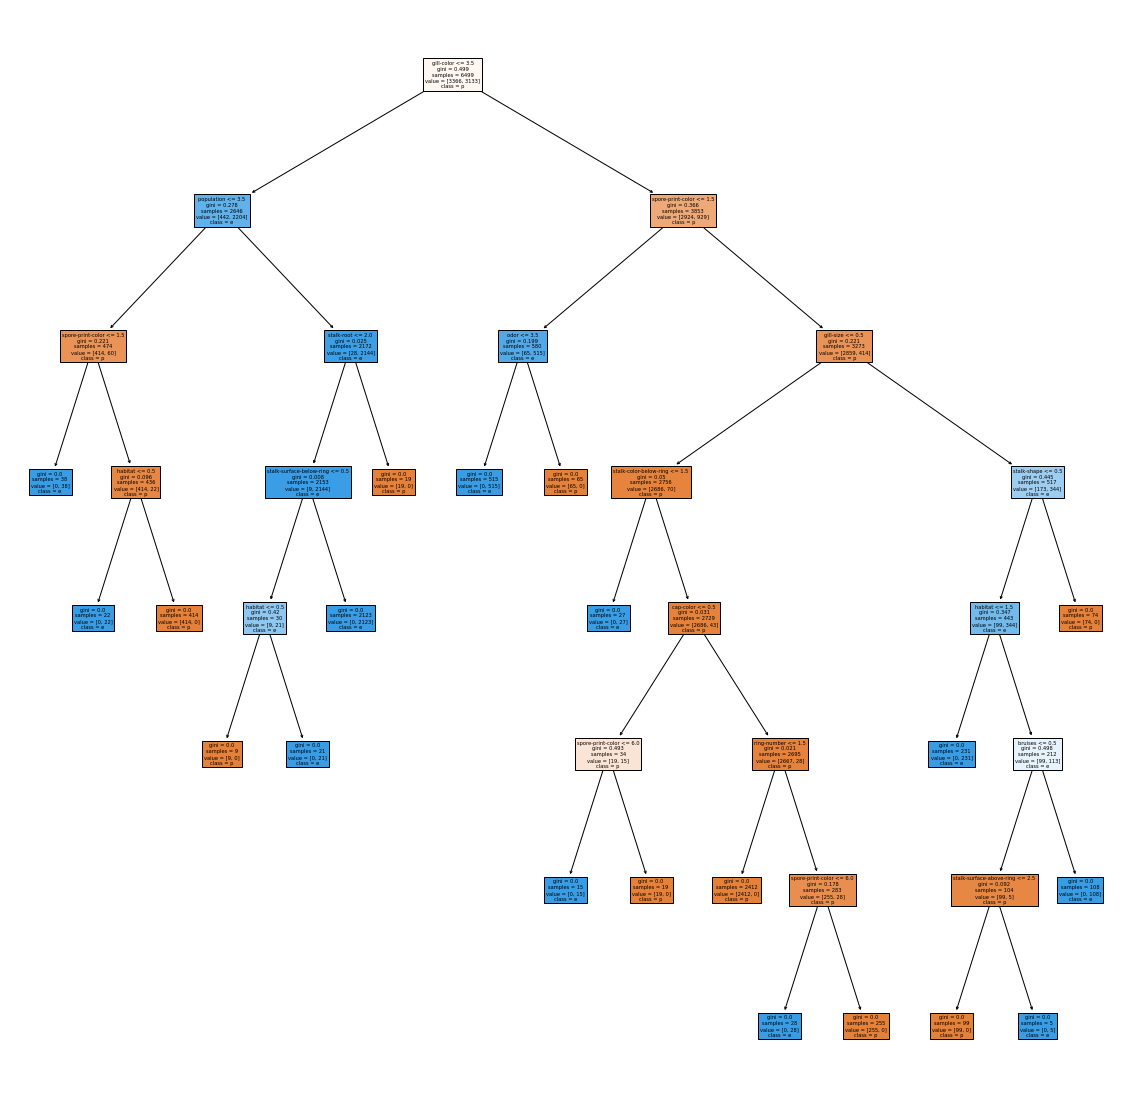

In [48]:
# Let's have a look at our decision tree - plot it using plot_tree
plt.figure(figsize=(20,20))
features = list(df_mush.drop('class', axis=1).columns)
classes = ['p','e']
plot_tree(dt,feature_names=features, class_names=classes, filled=True)
plt.show()

In [49]:
# Use heapq to print the features in order of importance
import heapq
sorted = list()
for score,feat in zip(dt.feature_importances_, features):
    heapq.heappush(sorted,(score,feat))
heapq.nlargest(len(sorted),sorted)

[(0.3386333245361517, 'gill-color'),
 (0.2161796062737091, 'spore-print-color'),
 (0.17756146811019494, 'population'),
 (0.10988184292692572, 'gill-size'),
 (0.035568424007609956, 'odor'),
 (0.03161280550485174, 'habitat'),
 (0.029586730436572603, 'bruises'),
 (0.023562771190919596, 'stalk-shape'),
 (0.015961182464033455, 'stalk-color-below-ring'),
 (0.011509894494867228, 'stalk-root'),
 (0.0038399987006644478, 'cap-color'),
 (0.0029332149516242945, 'stalk-surface-above-ring'),
 (0.0016407475292801736, 'stalk-surface-below-ring'),
 (0.0015279888725950005, 'ring-number'),
 (0.0, 'veil-type'),
 (0.0, 'veil-color'),
 (0.0, 'stalk-color-above-ring'),
 (0.0, 'ring-type'),
 (0.0, 'gill-spacing'),
 (0.0, 'gill-attachment'),
 (0.0, 'cap-surface'),
 (0.0, 'cap-shape')]